In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Input, Flatten, concatenate
from keras import Model
from keras.metrics import RootMeanSquaredError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LinearRegression

### Load data

In [2]:
df = None
with open("covid_flow.pkl", "rb") as f:
    df = pickle.load(f)
df["case"] = df.index
df["t_point"] = df["t_point"].apply(lambda x: x[2:])
df["t_point"] = df["t_point"].apply(lambda x: int(x))
df.set_index(["case", "t_point"], inplace=True)
df = df.sort_values(["case", "t_point"])

#### Function which shows results of model

In [3]:
# Function which shows results of model
def show_results(X_test, y_test, model, history, batch_size=None, sample_num = 0):
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.legend(["train loss", "validation loss"])

    y_pred = model.predict(X_test, batch_size=batch_size, verbose=0)

    r2_scor = r2_score(y_test, y_pred, multioutput="raw_values")
    mse_score = mean_squared_error(y_test, y_pred, multioutput="raw_values")

    table=[]
    table.append(mse_score)
    table.append(r2_scor)

    df_score = pd.DataFrame(table, ["MSE", "R2"], columns=df.columns[29:42])
    df_score.to_csv("reports_w3/"+model.name+".csv")
    model.save("models_w3/"+model.name)
    display(df_score)
    plt.show()
    

## Train Models

#### Window 3

In [4]:
import prepare_data_covid as datacovid
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_dynamic(df_input=df, window=3)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train, y_train), (X_test[1:], y_test[1:]), (X_val[1:], y_val[1:])
X_train.shape

TRAIN shape:  (712, 3, 13)
TEST shape:  (89, 13)
VAL shape:  (89, 13)


(712, 3, 13)

#### FNN

Model: "Faltten1Layer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 39)                0         
                                                                 
 dense (Dense)               (None, 32)                1280      
                                                                 
 dense_1 (Dense)             (None, 13)                429       
                                                                 
Total params: 1,709
Trainable params: 1,709
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] - 2s 33ms/step - loss: 0.1149 - val_loss: 0.0670
Epoch 2/30
23/23 [==============================] - 0s 19ms/step - loss: 0.0431 - val_loss: 0.0266
Epoch 3/30
23/23 [==============================] - 0s 18ms/step - loss: 0.0216 - val_loss: 0.0198
Epoch 4/30
23/23 [

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002776,0.002849,0.001437,0.013697,0.000429,0.002556,0.004063,0.006340,0.007779,0.001576,0.032655,0.001335,0.005420
R2,-1.247323,0.698661,-0.978406,-0.246791,-0.519388,-0.232048,0.662094,0.005256,0.569456,0.982839,-0.097756,-0.704417,0.505689


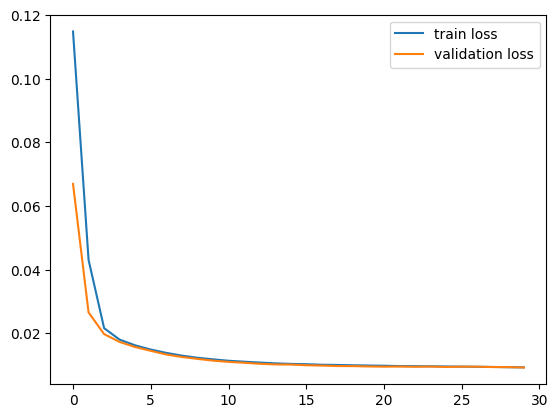

In [5]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW=X_train.shape[1]
model = Sequential(name="Faltten1Layer")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(32, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten3Layers"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 39)                0         
                                                                 
 dense_2 (Dense)             (None, 39)                1560      
                                                                 
 dense_3 (Dense)             (None, 13)                520       
                                                                 
 dense_4 (Dense)             (None, 13)                182       
                                                                 
 dense_5 (Dense)             (None, 13)                182       
                                                                 
Total params: 2,444
Trainable params: 2,444
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
23/23 [==============================] 

,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002060,0.007782,0.000526,0.013463,0.000272,0.002094,0.008225,0.006498,0.009045,0.001138,0.031168,0.000821,0.010235
R2,-0.667435,0.176988,0.275951,-0.225525,0.037945,-0.008984,0.315952,-0.019594,0.499369,0.987608,-0.047775,-0.048160,0.066522


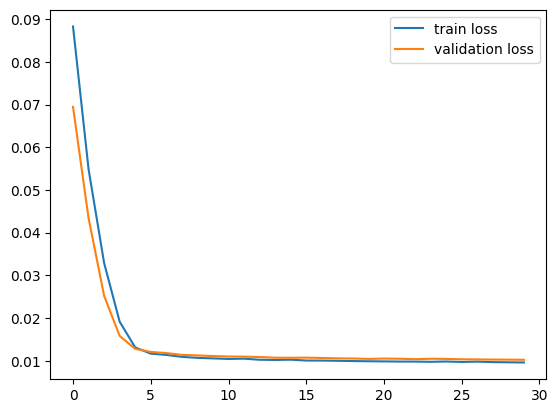

In [6]:
model = Sequential(name="Flatten3Layers")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(WINDOW*PARAMS_LENGTH, activation="relu"))
model.add(Dense(13, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="relu"))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=30, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

#### RNN

Simple RNN with linear activation 

Model: "SimpleRNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 13)                351       
                                                                 
 dense_6 (Dense)             (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002303,0.008708,0.000928,0.014243,0.000727,0.002036,0.008975,0.006125,0.010567,0.002621,0.032328,0.000940,0.006847
R2,-0.864621,0.079011,-0.277157,-0.296463,-1.573080,0.018570,0.253566,0.038948,0.415100,0.971452,-0.086761,-0.200337,0.375554


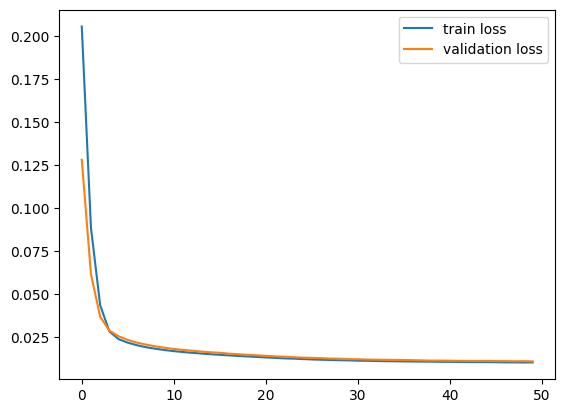

In [7]:
model = Sequential(name="SimpleRNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN sigmoid

Model: "SimpleRNN13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 13)                351       
                                                                 
 dense_7 (Dense)             (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001544,0.009056,0.000792,0.012556,0.000488,0.002382,0.006707,0.006537,0.014024,0.004922,0.033419,0.000911,0.006813
R2,-0.250100,0.042306,-0.090042,-0.142972,-0.727543,-0.148161,0.442174,-0.025658,0.223808,0.946391,-0.123439,-0.162244,0.378648


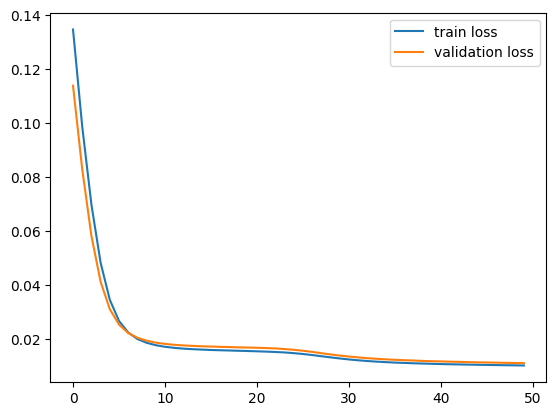

In [8]:
PARAMS_LENGTH = X_train.shape[2]
WINDOW = X_train.shape[1]
model = Sequential(name="SimpleRNN13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

SimpleRNN with Tanh activation

Model: "SimpleRNN13_Tanh"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 13)                351       
                                                                 
 dense_8 (Dense)             (None, 13)                182       
                                                                 
Total params: 533
Trainable params: 533
Non-trainable params: 0
_________________________________________________________________
INFO:tensorflow:Assets written to: models_w3/SimpleRNN13_Tanh\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001267,0.009313,0.000627,0.012323,0.000286,0.002175,0.009118,0.007298,0.011151,0.003717,0.031547,0.000663,0.005834
R2,-0.025246,0.015034,0.136553,-0.121761,-0.011132,-0.048052,0.241675,-0.145036,0.382807,0.959516,-0.060515,0.153958,0.467910


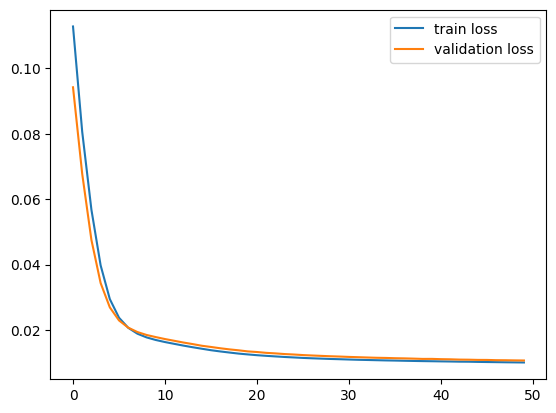

In [9]:
model = Sequential(name="SimpleRNN13_Tanh")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="sigmoid"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val),  verbose=0)
show_results(X_test, y_test, model, history)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (8, 13)                   1404      
                                                                 
 dense_9 (Dense)             (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001800,0.001480,0.000308,0.012621,0.000154,0.001733,0.003604,0.005433,0.006612,0.000376,0.036457,0.000356,0.004082
R2,-0.457097,0.843488,0.575890,-0.148812,0.456222,0.164845,0.700266,0.147541,0.634053,0.995900,-0.225569,0.546152,0.627703


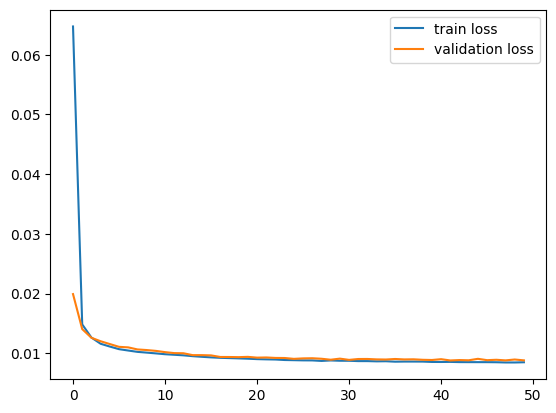

In [10]:
BATCH_SIZE=8

model = Sequential(name="LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (4, 13)                   1404      
                                                                 
 dense_10 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001558,0.001280,0.000296,0.014236,0.000131,0.003088,0.003366,0.005930,0.006518,0.000861,0.033681,0.000458,0.003824
R2,-0.260830,0.864683,0.593188,-0.295819,0.536258,-0.488392,0.720061,0.069593,0.639211,0.990622,-0.132255,0.415641,0.651211


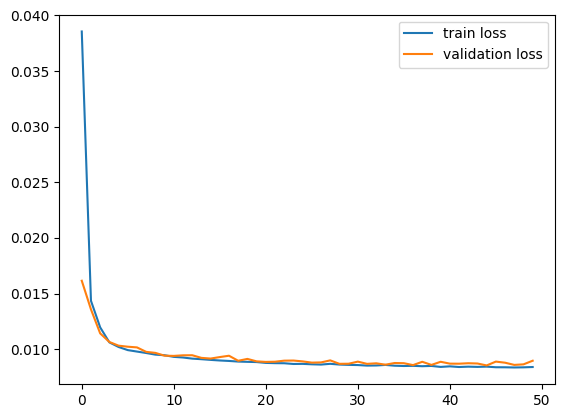

In [11]:
BATCH_SIZE=4

model = Sequential(name="LSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (2, 13)                   1404      
                                                                 
 dense_11 (Dense)            (2, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001555,0.000400,0.000583,0.013890,0.000203,0.004234,0.003340,0.005001,0.006603,0.000715,0.034917,0.000660,0.004579
R2,-0.259092,0.957671,0.196879,-0.264388,0.282749,-1.040474,0.722249,0.215343,0.634500,0.992208,-0.173802,0.157162,0.582361


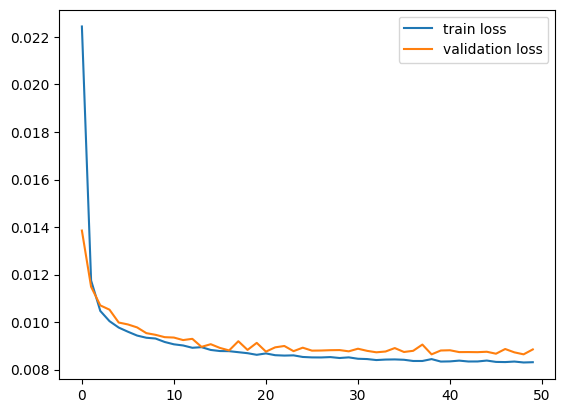

In [12]:
BATCH_SIZE=2

model = Sequential(name="LSTM13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "6_LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (1, 13)                   1404      
                                                                 
 dense_12 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/6_LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001424,0.000066,0.000276,0.012085,0.000118,0.003098,0.003686,0.004642,0.006974,0.000418,0.039499,0.000377,0.004228
R2,-0.152573,0.993044,0.620399,-0.100054,0.584104,-0.493193,0.693403,0.271687,0.613988,0.995449,-0.327835,0.519144,0.614368


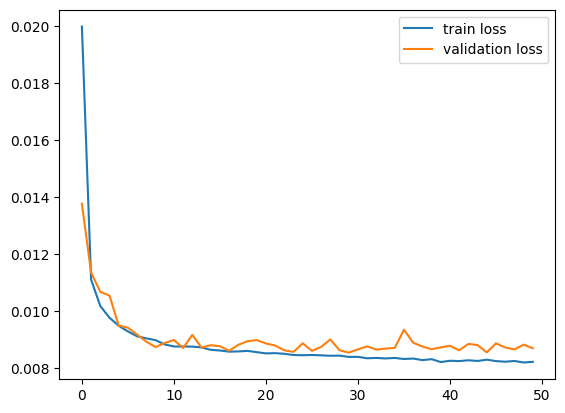

In [13]:
BATCH_SIZE=1

model = Sequential(name="LSTM13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

### LSTM

LSTM 13 units and linear

Model: "LSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 13)                1404      
                                                                 
 dense_13 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001435,0.004947,0.000788,0.015097,0.000288,0.001592,0.008600,0.006144,0.007556,0.000859,0.031094,0.000414,0.007646
R2,-0.161715,0.476840,-0.084256,-0.374281,-0.019889,0.232829,0.284742,0.035953,0.581803,0.990644,-0.045297,0.471150,0.302665


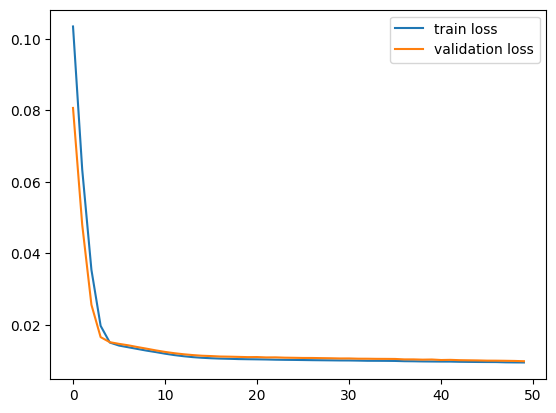

In [14]:
model = Sequential(name="LSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTMWithMore Units

Model: "LSTM32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 32)                5888      
                                                                 
 dense_14 (Dense)            (None, 13)                429       
                                                                 
Total params: 6,317
Trainable params: 6,317
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM32\assets


INFO:tensorflow:Assets written to: models_w3/LSTM32\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001352,0.001361,0.000442,0.013594,0.000235,0.001655,0.004021,0.006291,0.006958,0.001411,0.031057,0.000492,0.003838
R2,-0.094718,0.856015,0.391543,-0.237424,0.168839,0.202268,0.665568,0.012929,0.614901,0.984632,-0.044031,0.371947,0.649994


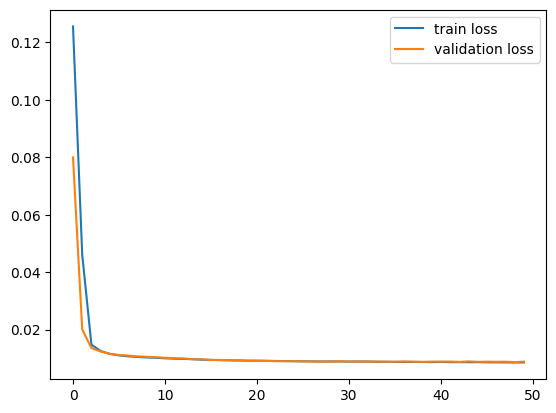

In [15]:
model = Sequential(name="LSTM32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "LSTM64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64)                19968     
                                                                 
 dense_15 (Dense)            (None, 13)                845       
                                                                 
Total params: 20,813
Trainable params: 20,813
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM64\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001527,0.000694,0.000220,0.012930,0.000190,0.003287,0.003424,0.006199,0.006766,0.000766,0.033002,0.000628,0.004360
R2,-0.236099,0.926602,0.697655,-0.176952,0.327126,-0.584162,0.715206,0.027389,0.625488,0.991656,-0.109430,0.198163,0.602369


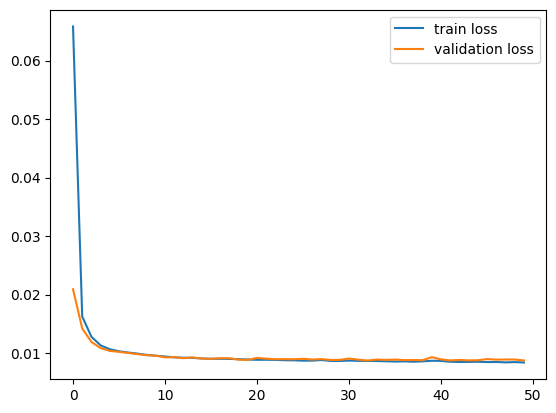

In [16]:
model = Sequential(name="LSTM64")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM with batch

Model: "LSTM13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (8, 13)                   1404      
                                                                 
 dense_16 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch8\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch8\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001267,0.001321,0.00044,0.013057,0.000229,0.001844,0.003346,0.005416,0.007343,0.001213,0.031977,0.000582,0.003809
R2,-0.025273,0.860335,0.39431,-0.188571,0.189043,0.111199,0.721695,0.150201,0.593590,0.986785,-0.074954,0.257379,0.652576


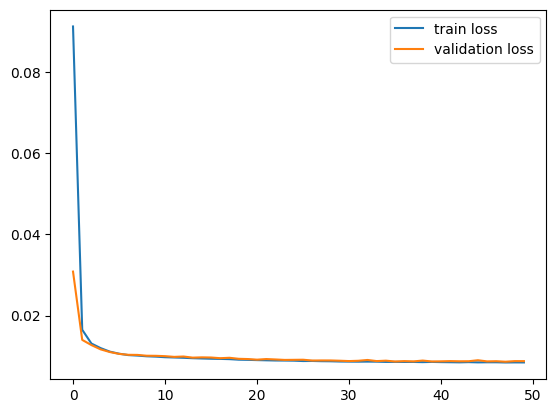

In [17]:
BATCH_SIZE=8

model = Sequential(name="LSTM13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (4, 13)                   1404      
                                                                 
 dense_17 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001316,0.000587,0.000805,0.013076,0.000213,0.001875,0.004031,0.005306,0.006579,0.000876,0.038934,0.000768,0.003762
R2,-0.065043,0.937955,-0.107709,-0.190250,0.247733,0.096168,0.664721,0.167466,0.635875,0.990460,-0.308831,0.019972,0.656922


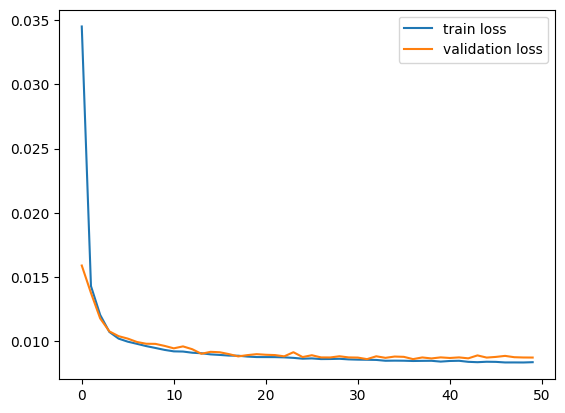

In [18]:
BATCH_SIZE=4
model = Sequential(name="LSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (2, 13)                   1404      
                                                                 
 dense_18 (Dense)            (2, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch2\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001521,0.000189,0.000217,0.014807,0.000182,0.002691,0.003369,0.005152,0.006536,0.000655,0.039766,0.000539,0.003951
R2,-0.231551,0.979963,0.701792,-0.347858,0.354564,-0.297045,0.719808,0.191574,0.638230,0.992868,-0.336815,0.311495,0.639641


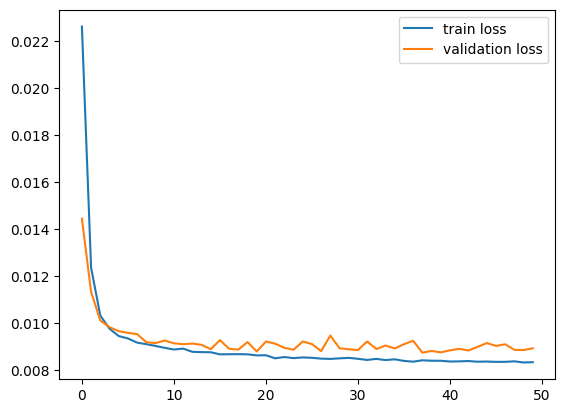

In [19]:
BATCH_SIZE=2
model = Sequential(name="LSTM13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM13_Batch1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (1, 13)                   1404      
                                                                 
 dense_19 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,586
Trainable params: 1,586
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch1\assets


INFO:tensorflow:Assets written to: models_w3/LSTM13_Batch1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001582,0.00036,0.000298,0.013982,0.000103,0.003868,0.004808,0.005254,0.006861,0.001062,0.033792,0.000520,0.004284
R2,-0.280880,0.96195,0.590428,-0.272761,0.634257,-0.864045,0.600128,0.175612,0.620248,0.988438,-0.135998,0.336498,0.609307


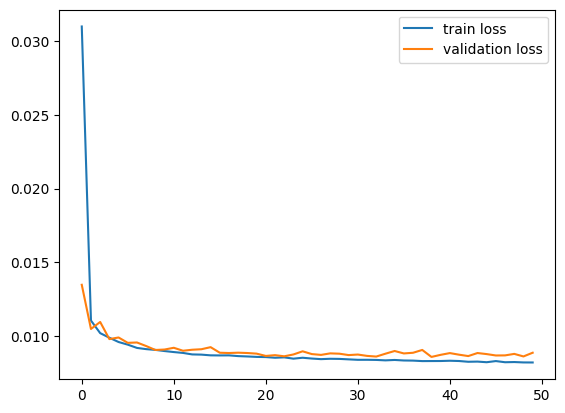

In [20]:
BATCH_SIZE=1
model = Sequential(name="LSTM13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train,
 epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

LSTM to LSTM

Model: "LSTM64xLSTM13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 3, 32)             5888      
                                                                 
 lstm_12 (LSTM)              (None, 13)                2392      
                                                                 
 dense_20 (Dense)            (None, 13)                182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001894,0.004099,0.000504,0.01465,0.000337,0.001572,0.004610,0.006568,0.008918,0.000445,0.033472,0.001088,0.004212
R2,-0.533182,0.566448,0.306761,-0.33358,-0.191887,0.242244,0.616588,-0.030610,0.506392,0.995149,-0.125232,-0.388131,0.615865


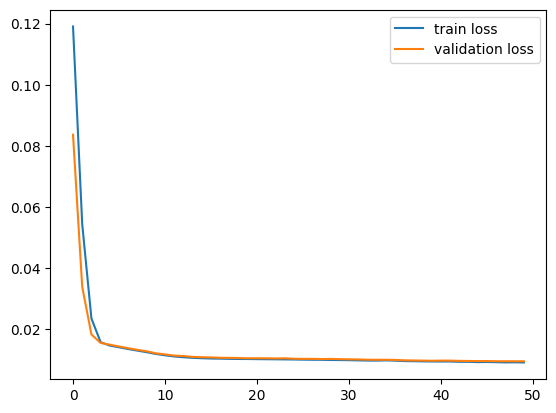

In [21]:
model = Sequential(name="LSTM64xLSTM13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM64xLSTM13_Batch4

Model: "LSTM64xLSTM13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_13 (LSTM)              (4, 3, 32)                5888      
                                                                 
 lstm_14 (LSTM)              (4, 13)                   2392      
                                                                 
 dense_21 (Dense)            (4, 13)                   182       
                                                                 
Total params: 8,462
Trainable params: 8,462
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001312,0.001053,0.000703,0.012140,0.000153,0.001617,0.003459,0.006599,0.007181,0.000654,0.040147,0.000771,0.004047
R2,-0.061984,0.888616,0.032321,-0.105108,0.459818,0.220799,0.712304,-0.035410,0.602559,0.992876,-0.349611,0.015761,0.630938


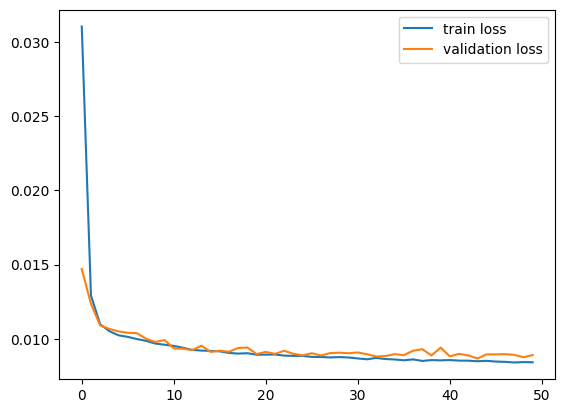

In [22]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(32, return_sequences=True))
model.add(LSTM(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

Model: "LSTM64_LSTM32_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 3, 64)             19968     
                                                                 
 lstm_16 (LSTM)              (None, 32)                12416     
                                                                 
 dense_22 (Dense)            (None, 13)                429       
                                                                 
Total params: 32,813
Trainable params: 32,813
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64_LSTM32_Dense\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64_LSTM32_Dense\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001360,0.001181,0.000464,0.012507,0.000209,0.001486,0.003746,0.006213,0.006888,0.000988,0.032883,0.000553,0.003961
R2,-0.101097,0.875142,0.361812,-0.138491,0.260386,0.283741,0.688426,0.025201,0.618729,0.989244,-0.105416,0.294772,0.638775


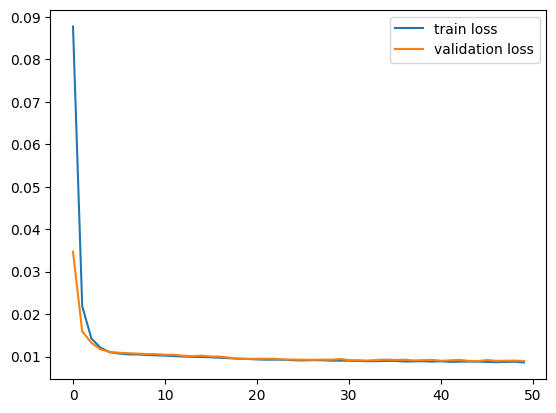

In [23]:
model = Sequential(name="LSTM64_LSTM32_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

LSTM64xLSTM32_Batch4

Model: "LSTM64xLSTM32_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_17 (LSTM)              (4, 3, 64)                19968     
                                                                 
 lstm_18 (LSTM)              (4, 32)                   12416     
                                                                 
 dense_23 (Dense)            (4, 13)                   429       
                                                                 
Total params: 32,813
Trainable params: 32,813
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM32_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/LSTM64xLSTM32_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001396,0.000082,0.000347,0.011386,0.000174,0.002374,0.003380,0.005125,0.006520,0.001032,0.036625,0.000392,0.003863
R2,-0.130267,0.991304,0.522513,-0.036390,0.384319,-0.144013,0.718857,0.195863,0.639118,0.988760,-0.231231,0.499811,0.647716


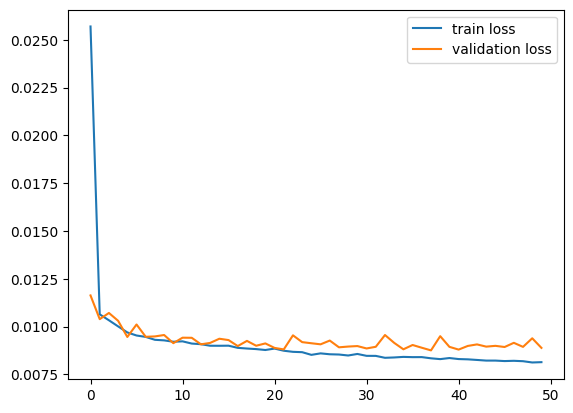

In [24]:
BATCH_SIZE=4
model = Sequential(name="LSTM64xLSTM32_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

#### GRU

Model: "GRU13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 13)                1092      
                                                                 
 dense_24 (Dense)            (None, 13)                182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


INFO:tensorflow:Assets written to: models_w3/GRU13\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001724,0.003551,0.000414,0.015108,0.000305,0.001515,0.005301,0.006228,0.007209,0.000734,0.031552,0.000646,0.004184
R2,-0.395437,0.624420,0.429790,-0.375197,-0.078367,0.270063,0.559090,0.022819,0.601012,0.992006,-0.060690,0.175208,0.618453


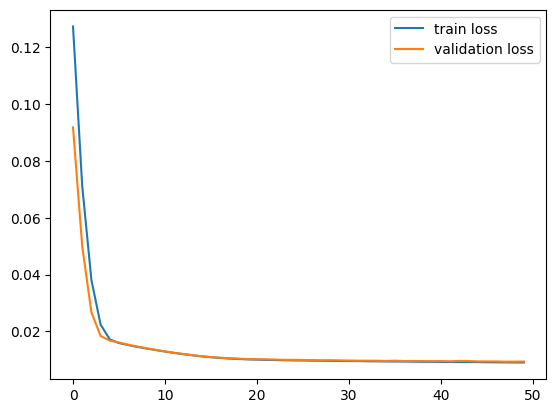

In [25]:
model = Sequential(name="GRU13")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

In [26]:
BATCH_SIZE = 8
model = Sequential(name="GRU13_Batch8")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU13_Batch8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (8, 13)                   1092      
                                                                 
 dense_25 (Dense)            (8, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


Model: "GRU13_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (4, 13)                   1092      
                                                                 
 dense_52 (Dense)            (4, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001753,0.000133,0.000360,0.013733,0.000342,0.001257,0.005527,0.005107,0.007728,0.023471,0.040141,0.000541,0.006081
R2,-0.071800,0.983836,-0.574585,0.022026,0.160488,-0.158701,0.466149,0.191079,0.649252,0.679430,-0.156447,-0.155099,0.471480


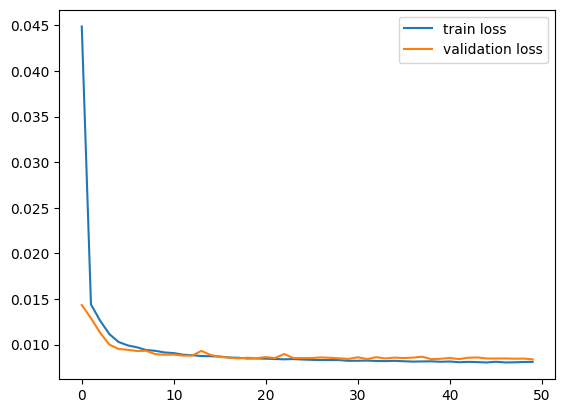

In [ ]:
BATCH_SIZE = 4
model = Sequential(name="GRU13_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU13_Batch2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (2, 13)                   1092      
                                                                 
 dense_53 (Dense)            (2, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch2\assets


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch2\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001738,0.000238,0.000223,0.012709,0.000320,0.001214,0.005279,0.005065,0.008035,0.023382,0.041713,0.000355,0.005342
R2,-0.062240,0.971117,0.025741,0.094946,0.215461,-0.118786,0.490169,0.197745,0.635330,0.680657,-0.201724,0.241757,0.535703


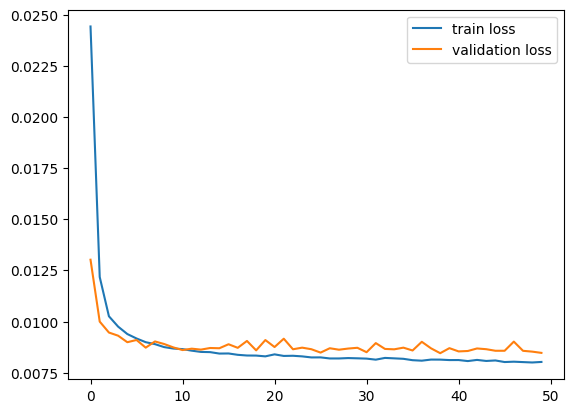

In [ ]:
BATCH_SIZE = 2
model = Sequential(name="GRU13_Batch2")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU13_Batch1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (1, 13)                   1092      
                                                                 
 dense_54 (Dense)            (1, 13)                   182       
                                                                 
Total params: 1,274
Trainable params: 1,274
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch1\assets


INFO:tensorflow:Assets written to: models_w3/GRU13_Batch1\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001666,0.000103,0.000680,0.01382,0.000386,0.001488,0.006248,0.005133,0.007676,0.023805,0.043185,0.001007,0.006208
R2,-0.018549,0.987485,-1.970092,0.01588,0.051708,-0.371848,0.396590,0.186925,0.651591,0.674873,-0.244147,-1.150180,0.460457


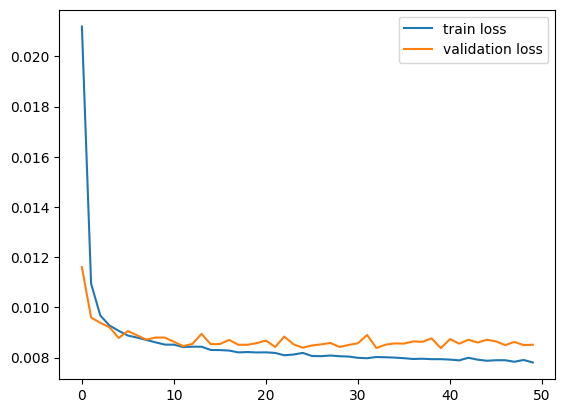

In [ ]:
BATCH_SIZE = 1
model = Sequential(name="GRU13_Batch1")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_5 (GRU)                 (None, 32)                4512      
                                                                 
 dense_55 (Dense)            (None, 13)                429       
                                                                 
Total params: 4,941
Trainable params: 4,941
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU32\assets


INFO:tensorflow:Assets written to: models_w3/GRU32\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002052,0.000344,0.000272,0.012790,0.000425,0.000980,0.006603,0.005098,0.007803,0.023095,0.040502,0.000422,0.005227
R2,-0.254257,0.958218,-0.189989,0.089214,-0.042922,0.096774,0.362250,0.192467,0.645842,0.684574,-0.166835,0.098710,0.545756


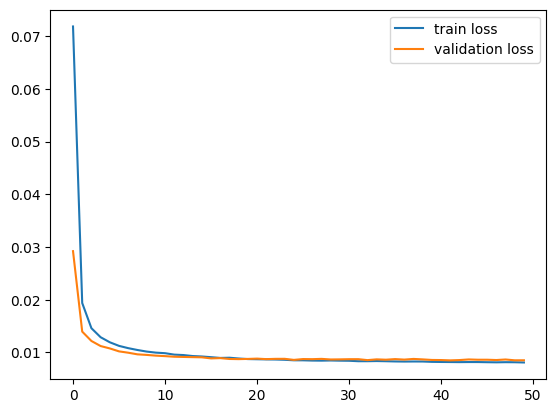

In [ ]:
model = Sequential(name="GRU32")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "GRU64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                15168     
                                                                 
 dense_56 (Dense)            (None, 13)                845       
                                                                 
Total params: 16,013
Trainable params: 16,013
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU64\assets


INFO:tensorflow:Assets written to: models_w3/GRU64\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001741,0.000057,0.000361,0.013227,0.000318,0.000990,0.005049,0.005044,0.007671,0.022956,0.039191,0.000422,0.005589
R2,-0.063995,0.993037,-0.576521,0.058052,0.218251,0.087135,0.512370,0.201095,0.651829,0.686471,-0.129081,0.100157,0.514250


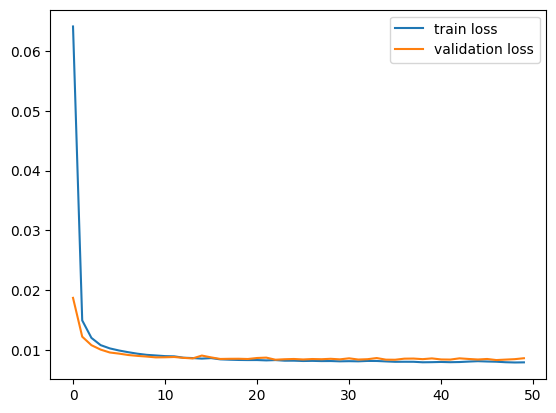

In [ ]:
model = Sequential(name="GRU64")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(64, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "GRU32_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (4, 32)                   4512      
                                                                 
 dense_57 (Dense)            (4, 13)                   429       
                                                                 
Total params: 4,941
Trainable params: 4,941
Non-trainable params: 0
_________________________________________________________________


INFO:tensorflow:Assets written to: models_w3/GRU32_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/GRU32_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001760,0.000105,0.000477,0.012890,0.000337,0.001250,0.005804,0.005055,0.009913,0.023059,0.041442,0.000471,0.005777
R2,-0.076007,0.987223,-1.084554,0.082082,0.173728,-0.152245,0.439401,0.199264,0.550065,0.685066,-0.193936,-0.004626,0.497896


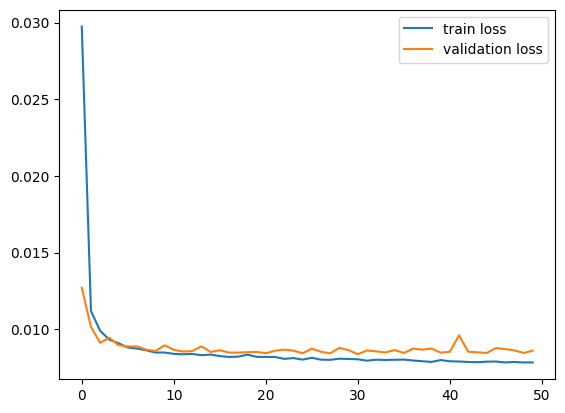

In [ ]:
BATCH_SIZE = 4
model = Sequential(name="GRU32_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0, batch_size=BATCH_SIZE)
show_results(X_test, y_test, model, history , batch_size=BATCH_SIZE)

Model: "GRU64_GRU13_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 3, 32)             4512      
                                                                 
 gru_9 (GRU)                 (None, 13)                1833      
                                                                 
 dense_58 (Dense)            (None, 13)                182       
                                                                 
Total params: 6,527
Trainable params: 6,527
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/GRU64_GRU13_Dense\assets


INFO:tensorflow:Assets written to: models_w3/GRU64_GRU13_Dense\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001921,0.000592,0.000395,0.013648,0.000464,0.001148,0.005414,0.005484,0.007902,0.023032,0.044600,0.000666,0.005526
R2,-0.174226,0.928063,-0.727568,0.028099,-0.140003,-0.058308,0.477111,0.131354,0.641339,0.685428,-0.284909,-0.422424,0.519777


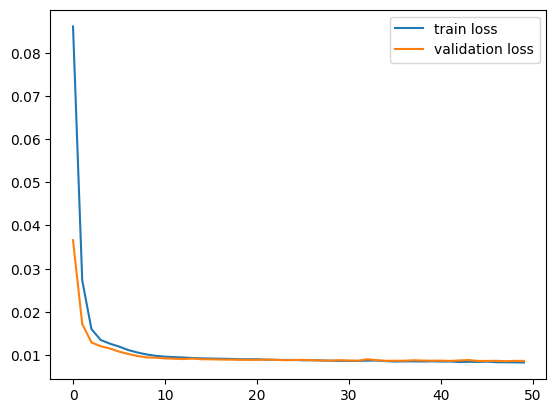

In [ ]:
model = Sequential(name="GRU64_GRU13_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(32, return_sequences=True))
model.add(GRU(PARAMS_LENGTH, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "GRU64_GRU32_Dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 3, 64)             15168     
                                                                 
 gru_11 (GRU)                (None, 32)                9408      
                                                                 
 dense_59 (Dense)            (None, 13)                429       
                                                                 
Total params: 25,005
Trainable params: 25,005
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/GRU64_GRU32_Dense\assets


INFO:tensorflow:Assets written to: models_w3/GRU64_GRU32_Dense\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001809,0.000312,0.000361,0.013495,0.000653,0.000968,0.005029,0.005116,0.007690,0.022971,0.040542,0.000466,0.005176
R2,-0.106017,0.962137,-0.576626,0.038981,-0.601977,0.107299,0.514300,0.189635,0.650974,0.686262,-0.168002,0.004721,0.550181


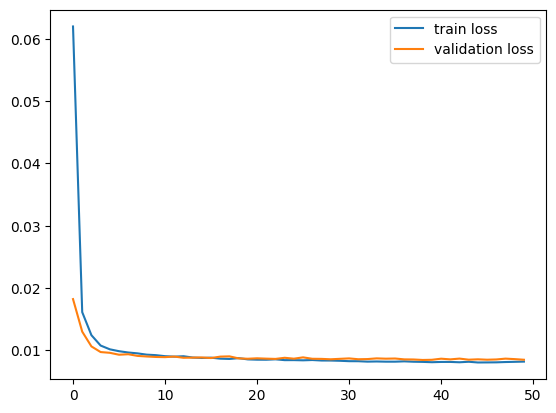

In [ ]:
model = Sequential(name="GRU64_GRU32_Dense")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(64, return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), verbose=0)
show_results(X_test, y_test, model, history)

Model: "GRU32xGRU32_Batch4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (4, 3, 32)                4512      
                                                                 
 gru_13 (GRU)                (4, 32)                   6336      
                                                                 
 dense_60 (Dense)            (4, 13)                   429       
                                                                 
Total params: 11,277
Trainable params: 11,277
Non-trainable params: 0
_________________________________________________________________
None


INFO:tensorflow:Assets written to: models_w3/GRU32xGRU32_Batch4\assets


INFO:tensorflow:Assets written to: models_w3/GRU32xGRU32_Batch4\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001971,0.000248,0.000215,0.013913,0.000373,0.001555,0.005338,0.004921,0.008190,0.023612,0.049146,0.000454,0.005875
R2,-0.205099,0.969840,0.061088,0.009253,0.085351,-0.433365,0.484418,0.220518,0.628262,0.677510,-0.415873,0.031101,0.489426


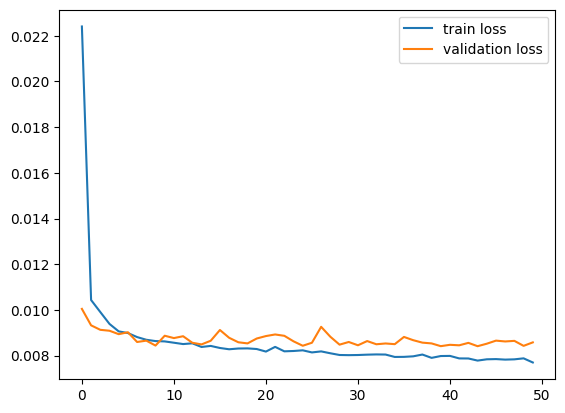

In [ ]:
BATCH_SIZE=4
model = Sequential(name="GRU32xGRU32_Batch4")
model.add(Input((WINDOW, PARAMS_LENGTH), batch_size=BATCH_SIZE))
model.add(GRU(32, return_sequences=True))
model.add(GRU(32, return_sequences=False))
model.add(Dense(PARAMS_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
print(model.summary())
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, verbose=0)
show_results(X_test, y_test, model, history, batch_size=BATCH_SIZE)

## Train with static parameters


Lets define new function for splitting

In [ ]:
(X_train, y_train), (X_test, y_test), (X_val, y_val) = \
datacovid.prepare_data_with_static(df_input=df, window=3)
(X_train, y_train), (X_test, y_test), (X_val, y_val) =\
    (X_train[1:], y_train[1:]), (X_test[1:], y_test[1:]), (X_val[2:], y_val[2:])

#### FNN

Flatten3Layers_Mixed

In [ ]:
model = Sequential(name="Flatten3Layers_Mixed")
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

Model: "Flatten3Layers_Mixed_flatten"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 141)               0         
                                                                 
 dense_61 (Dense)            (None, 128)               18176     
                                                                 
 dense_62 (Dense)            (None, 64)                8256      
                                                                 
 dense_63 (Dense)            (None, 32)                2080      
                                                                 
 dense_64 (Dense)            (None, 13)                429       
                                                                 
Total params: 28,941
Trainable params: 28,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [================

INFO:tensorflow:Assets written to: models_w3/Flatten3Layers_Mixed_flatten\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.002711,0.001499,0.001502,0.015228,0.000733,0.006966,0.012477,0.006300,0.010145,0.019752,0.076476,0.001513,0.007550
R2,-0.510571,-37.760025,-2.974254,-0.577828,-1.965868,-0.467221,0.307071,-0.131167,0.153941,0.784870,-0.249742,-0.798008,0.383203


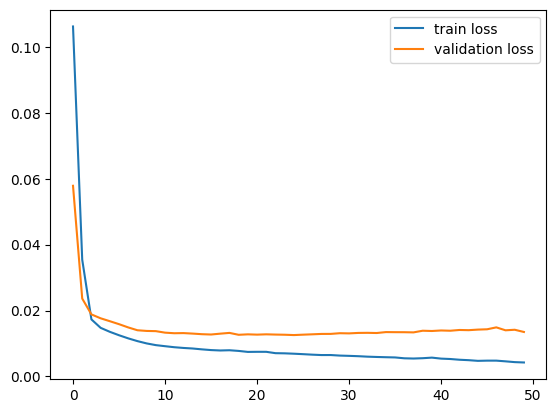

In [ ]:
model = Sequential(name="Flatten3Layers_Mixed_flatten")
PARAMS_LENGTH=X_train.shape[2]
TARGET_LENGTH=y_train.shape[1]
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model.compile(optimizer="adam", loss="mse")
model.summary()
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model, history)

#### RNN

RNN32Mixed

RNN - all info in the vectors

Model: "RNN32Mixed"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, 60)                6480      
                                                                 
 dense_65 (Dense)            (None, 13)                793       
                                                                 
Total params: 7,273
Trainable params: 7,273
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
23/23 [==============================] - 2s 26ms/step - loss: 0.2112 - val_loss: 0.0905
Epoch 2/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0618 - val_loss: 0.0470
Epoch 3/50
23/23 [==============================] - 0s 10ms/step - loss: 0.0383 - val_loss: 0.0350
Epoch 4/50
23/23 [==============================] - 0s 7ms/step - loss: 0.0296 - val_loss: 0.0295
Epoch 5/50
23/23 [==============================] - 0s 7

INFO:tensorflow:Assets written to: models_w3/RNN32Mixed\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.004186,0.001580,0.001719,0.013758,0.001094,0.004729,0.013056,0.006961,0.010089,0.014732,0.064155,0.002718,0.007557
R2,-1.332172,-39.849669,-3.549316,-0.425513,-3.423486,0.003850,0.274911,-0.249762,0.158591,0.839543,-0.048409,-2.230317,0.382557


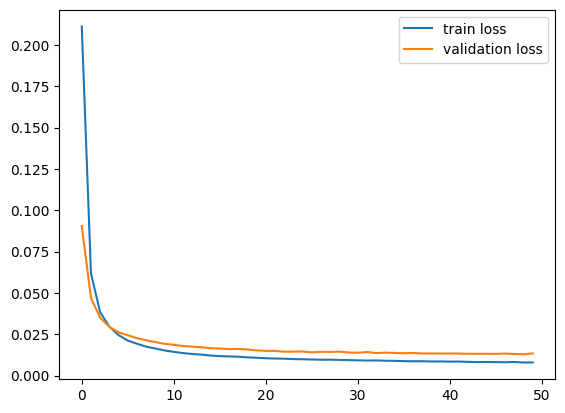

In [ ]:
RNN_LENGTH = PARAMS_LENGTH+TARGET_LENGTH
model = Sequential(name="RNN32Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(SimpleRNN(RNN_LENGTH, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

LSTM64Mixed

Model: "LSTM_StatDynam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 64)                28672     
                                                                 
 dense_28 (Dense)            (None, 13)                845       
                                                                 
Total params: 29,517
Trainable params: 29,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
105/105 [==============================] - 2s 7ms/step - loss: 0.0338 - val_loss: 0.0157
Epoch 2/50
105/105 [==============================] - 0s 3ms/step - loss: 0.0139 - val_loss: 0.0125
Epoch 3/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0115
Epoch 4/50
105/105 [==============================] - 0s 4ms/step - loss: 0.0104 - val_loss: 0.0108
Epoch 5/50
105/105 [========================

INFO:tensorflow:Assets written to: models_w3/LSTM_StatDynam\assets


INFO:tensorflow:Assets written to: models_w3/LSTM_StatDynam\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001554,0.000184,0.000290,0.007212,0.000149,0.001896,0.006167,0.007191,0.00922,0.000293,0.068481,0.000598,0.004936
R2,-0.112844,0.044098,0.023333,-0.066865,0.397859,0.054479,0.632094,0.216932,0.44063,0.995301,-0.045183,0.210255,0.619793


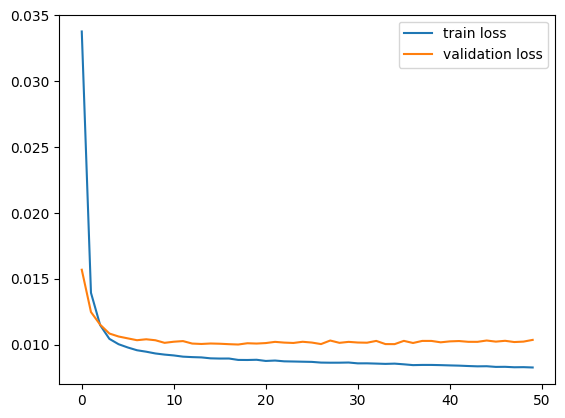

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
model = Sequential(name="LSTM64Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

LSTMtoLSTM_Mixed

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
model = Sequential(name="LSTMtoLSTM_Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(LSTM(64, return_sequences=True))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

GRU64Mixed

In [ ]:
PARAMS_LENGTH = X_train.shape[2]
TARGET_LENGTH = y_train.shape[1]
model = Sequential(name="GRU64Mixed")
model.add(Input((WINDOW, PARAMS_LENGTH)))
model.add(GRU(64, return_sequences=False))
model.add(Dense(TARGET_LENGTH, activation="linear"))
model_lstm = model
model_lstm.compile(optimizer="adam", loss="mse")
model_lstm.summary()
history = model_lstm.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val))
show_results(X_test, y_test, model_lstm, history)

RNN - dynamic and static params aparted

StaticDense_DynamicLSTM_oneLayer

In [ ]:
D_train = X_train[:, :, 29:]
S_train = X_train[:, 0, 0:29]
S_train = np.hstack([S_train, X_train[:, 0, 42:43]])
D_val = X_val[:, :, 29:]
S_val = X_val[:, 0, :29]
S_val = np.hstack([S_val, X_val[:, 0, 42:43]])


StaticDense_DynamicLSTM_oneLayer

Model: "StaticDense_DynamicLSTM_oneLayer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_29 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_28 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_17 (LSTM)                 (None, 40)           9440        ['input_29[0][0]']               
                                                                                                  
 dense_29 (Dense)               (None, 16)           496         ['input_28[0][0]']               
                                                                   

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_oneLayer\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_oneLayer\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001725,0.000063,0.004062,0.010225,0.000257,0.001178,0.006220,0.007178,0.011120,0.007738,0.068198,0.004867,0.005711
R2,0.032918,-0.104081,0.092533,-0.014513,0.280060,0.142073,0.571214,0.345500,0.287068,0.812218,0.035000,0.095090,0.592805


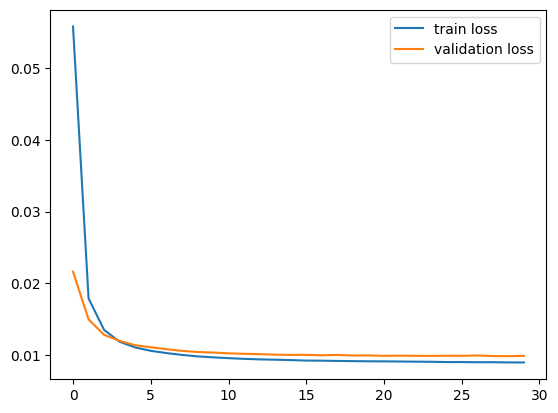

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(16, activation='relu')(input_static)
lstm_layer = LSTM(40, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(concatenate([lstm_layer, dense_layer]))
model = Model(name="StaticDense_DynamicLSTM_oneLayer", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")

history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=30)
show_results([S_val, D_val], y_val, model, history)

StaticDense_DynamicLSTM_twoLayers

LSTM - with two layers on the output

Model: "StaticDense_DynamicLSTM_twoLayers"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_31 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_30 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 lstm_18 (LSTM)                 (None, 64)           21248       ['input_31[0][0]']               
                                                                                                  
 dense_31 (Dense)               (None, 32)           992         ['input_30[0][0]']               
                                                                  

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_twoLayers\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicLSTM_twoLayers\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001792,0.000119,0.004152,0.010735,0.000286,0.001336,0.006333,0.007372,0.010722,0.007732,0.079551,0.004900,0.005180
R2,-0.004507,-1.087537,0.072425,-0.065076,0.198969,0.027222,0.563426,0.327791,0.312623,0.812369,-0.125641,0.089013,0.630691


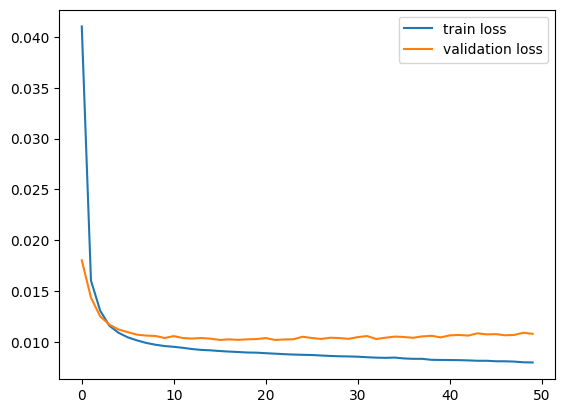

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = LSTM(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicLSTM_twoLayers", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)

StaticDense_DynamicGRU_twolayers

Model: "StaticDense_DynamicGRU"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 1, 18)]      0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 30)]         0           []                               
                                                                                                  
 gru_2 (GRU)                    (None, 64)           16128       ['input_33[0][0]']               
                                                                                                  
 dense_34 (Dense)               (None, 32)           992         ['input_32[0][0]']               
                                                                             

INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicGRU\assets


INFO:tensorflow:Assets written to: models_w3/StaticDense_DynamicGRU\assets


,Температура_dinam_fact,Лимфоциты#_dinam_fact,АСТ_dinam_fact,ЧСС_dinam_fact,ЧДД_dinam_fact,Билирубин общий_dinam_fact,MPV- Средн.объем тромбоцитов_dinam_fact,PCT- Тромбокрит_dinam_fact,Лимфоциты%_dinam_fact,снижение_сознания_dinam_fact,Cтепень тяжести по КТ_dinam_fact,Лактатдегидрогеназа_dinam_fact,PDW- Индекс расп.по объему тр._dinam_fact
MSE,0.001876,0.000119,0.004010,0.011439,0.000258,0.001264,0.005979,0.007604,0.010576,0.007806,0.078441,0.004762,0.005196
R2,-0.051543,-1.093470,0.104122,-0.134941,0.278475,0.079770,0.587839,0.306683,0.321981,0.810567,-0.109938,0.114653,0.629507


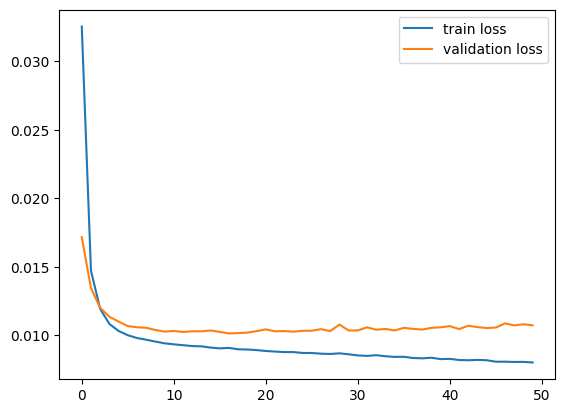

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
input_static = Input((SPARAMS_LENGTH))
input_dinamic = Input((WINDOW, DPARAMS_LENGTH))
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = GRU(64, return_state=False)(input_dinamic)
result_layer = Dense(32, activation="relu")(concatenate([lstm_layer, dense_layer]))
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicGRU_twolayers", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50)
show_results([S_val, D_val], y_val, model, history)

StaticDense_DynamicLSTM_batch4

LSTM as above but train dataset divided on batch to control overfit

In [ ]:
SPARAMS_LENGTH = S_train.shape[1]
DPARAMS_LENGTH = D_train.shape[2]
BATCH_SIZE=4
input_static = Input((SPARAMS_LENGTH), batch_size=BATCH_SIZE)
input_dinamic = Input((WINDOW, DPARAMS_LENGTH), batch_size=BATCH_SIZE)
dense_layer = Dense(32, activation='relu')(input_static)
lstm_layer = LSTM(64, return_state=False)(input_dinamic)
result_layer = Dense(13, activation='linear')(result_layer)
model = Model(name="StaticDense_DynamicLSTM_batch4", inputs=[input_static, input_dinamic], outputs=result_layer)
model.summary()
model.compile(optimizer="adam", loss="mse")
history = model.fit(x=[S_train, D_train], y=y_train, validation_data=([S_val, D_val], y_val), epochs=50, batch_size=BATCH_SIZE)
show_results([S_val, D_val], y_val, model, history, batch_size=BATCH_SIZE)

NameError: name 'S_train' is not defined